# Improving the model: Hyperparameter tuning with [Talos](https://autonomio.github.io/docs_talos/#scan)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.losses import LogCosh, BinaryCrossentropy
from tensorflow.keras.activations import relu, elu, sigmoid
from tensorflow.keras.optimizers import SGD, Adam, Nadam, RMSprop

import talos
from talos.model.normalizers import lr_normalizer
from talos import Predict, Evaluate

sns.set()
tf.__version__

Using TensorFlow backend.


'2.0.0'

In [2]:
data = pd.read_csv('dataset/exit_prediction.csv')
data.drop(labels=['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

# label/features
labels = data.pop('Exited')

# one-hot encoding
features = pd.get_dummies(data)
features.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,1,0


### Train/Test split

We will use 50% of the data for pure testing. The rest 50% we shall split into train/test.

In [3]:
train_features, pure_testing_features, train_labels, pure_testing_labels = train_test_split(features, labels,
                                                                    test_size=0.5, random_state=1, stratify=labels)

# Convert to numpy arrays and standardize
train_labels = train_labels.values
train_features = talos.utils.rescale_meanzero(train_features.values)

### Some useful documentations

1. Talos
    - The [Scan](https://autonomio.github.io/docs_talos/#scan) method: All of the options affecting the experiment, except for the hyperparameters, are defined here
    - [lr_optimizers](https://autonomio.github.io/docs_talos/#lr-normalizer): Allows one to define different learning rates for different kinds of optimizers
    - One can utilize 3 kinds of optimization strategies with Talos
        - Grid Search: by default Talos will try out every possible parameter specified. Not recommended ofc.
        - Random Search: use *grid_downsample=0.01* to use 1% of the data for instance.
        - [Probabilistic reduction](https://autonomio.github.io/docs_talos/#probabilistic-reduction): make a stop between the rounds, evaluate the worst performing parameter and then eliminate it from the remaining search space
    
    - Early Stopping: If gotten correctly (which is tricky) can dramatically improve run-time
2. Sequential model
    - [Docs](https://keras.io/guides/sequential_model/)
    - Appropriate for a plain stack of layers. A rather straightforward NN
    - Each layer has exactly one input & output tensor
3. Dense Layer
    - [Docs](https://keras.io/api/layers/core_layers/dense/)
    - [Docs](https://keras.io/api/layers/initializers/) on kernel initializers. Define the way to set the initial random weights of Keras layers.
    - [Docs](https://keras.io/api/layers/activations/) on activation functions
4. Dropout Layer
    - [Docs](https://keras.io/api/layers/regularization_layers/dropout/)
5. Loss Functions
    - [Docs](https://keras.io/api/losses/)
6. Optimizers
    - [Docs](https://keras.io/api/optimizers/)
7. compile
    - [Docs](https://keras.io/api/models/model_training_apis/)
8. fit
    - [Docs](https://keras.io/api/models/model_training_apis/)

In [4]:
def get_class_weights(labels):
    counter = Counter(labels)
    majority = max(counter.values())
    return {cls: float(majority/count) for cls, count in counter.items()}

get_class_weights(labels)

{1: 3.9091801669121256, 0: 1.0}

## First run of experiment

In [5]:
# Over 1 Million different combinations
params = {
    'layer1_units': list(range(20,100,9)),
    'layer2_units': list(range(20,60,5)),
    'layer3_units': list(range(20,40,3)),
    'optimizer': [Adam, Nadam, RMSprop],
    'lr': [0.1, 0.5, 1, 5],
    # kernel = weights
    'kernel_initializer': ['uniform', 'normal'],
    'use_bias': [True, False],
    'activation1': [relu, elu],
    'activation2': [sigmoid],
    'dropout': list(np.linspace(0, 0.4, 6)),
    # since this is a binary classification task
    'losses': ['binary_crossentropy', 'logcosh'],
    'epochs': list(range(100, 150, 6)),
    'batch_size': list(range(30, 70, 5)),
#     'class_weight': list(get_class_weights(train_labels).values()),
}

for k, v in params.items():
    print(k,":",v)

layer1_units : [20, 29, 38, 47, 56, 65, 74, 83, 92]
layer2_units : [20, 25, 30, 35, 40, 45, 50, 55]
layer3_units : [20, 23, 26, 29, 32, 35, 38]
optimizer : [<class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>, <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'>]
lr : [0.1, 0.5, 1, 5]
kernel_initializer : ['uniform', 'normal']
use_bias : [True, False]
activation1 : [<function relu at 0x000001B2CD3FE168>, <function elu at 0x000001B2CC9DCAF8>]
activation2 : [<function sigmoid at 0x000001B2CD3FE4C8>]
dropout : [0.0, 0.08, 0.16, 0.24, 0.32, 0.4]
losses : ['binary_crossentropy', 'logcosh']
epochs : [100, 106, 112, 118, 124, 130, 136, 142, 148]
batch_size : [30, 35, 40, 45, 50, 55, 60, 65]


In [6]:
def customer_exit_model(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    
    model.add(Dense(params['layer1_units'], input_dim=x_train.shape[1], activation=params['activation1'],
                   kernel_initializer=params['kernel_initializer']))
    model.add(Dense(params['layer2_units'], input_dim=x_train.shape[1], activation=params['activation1'],
                   kernel_initializer=params['kernel_initializer']))
    model.add(Dense(params['layer3_units'], input_dim=x_train.shape[1], activation=params['activation1'],
                   kernel_initializer=params['kernel_initializer']))
    model.add(Dropout(params['dropout']))
    model.add(Dense(1, activation=params['activation2'], kernel_initializer=params['kernel_initializer'], 
                                                                       use_bias=params['use_bias']))
    
    model.compile(loss=params['losses'], 
                  optimizer=params['optimizer'](lr_normalizer(params['lr'], params['optimizer'])),
                  # For this dataset, using accuracy as a metric is basically ok
                  metrics=['acc', talos.utils.metrics.f1score])

    history = model.fit(x_train, y_train, 
                   validation_data=[x_val, y_val],
                   batch_size=params['batch_size'],
#                    callbacks=[talos.utils.live()],
                   epochs=params['epochs'],
                   verbose=0,
                   shuffle=True,)

    return history, model

In [ ]:
# run for 1435 combinations
t = talos.Scan(x=train_features,
               y=train_labels,
               val_split=0.25,
               model=customer_exit_model,
               params=params,
               experiment_name='Customer exit prediction',
               fraction_limit = 0.00005,
#                random_method='quantum',
#                reduction_method='corelation',
#                reduction_interval=10,
#                reduction_window=20,
#                reduction_threshold=0.6,
#                reduction_metric='fmeasure',
              )



















  0%|          | 0/2090 [00:00<?, ?it/s]

















  0%|          | 1/2090 [00:34<19:52:52, 34.26s/it]

















  0%|          | 2/2090 [01:08<19:54:12, 34.32s/it]

















  0%|          | 3/2090 [01:41<19:34:37, 33.77s/it]

















  0%|          | 4/2090 [02:08<18:29:08, 31.90s/it]

















  0%|          | 5/2090 [02:54<20:57:28, 36.19s/it]

















  0%|          | 6/2090 [03:15<18:15:11, 31.53s/it]

















  0%|          | 7/2090 [03:53<19:17:49, 33.35s/it]

















  0%|          | 8/2090 [04:20<18:15:09, 31.56s/it]

















  0%|          | 9/2090 [04:51<18:03:23, 31.24s/it]

















  0%|          | 10/2090 [05:28<19:02:18, 32.95s/it]

















  1%|          | 11/2090 [06:11<20:51:57, 36.13s/it]

















  1%|          | 12/2090 [06:49<21:15:12, 36.82s/it]

















  1%|          | 13/2090 [07:16<19:23:17, 33.60s/it]

















  1%|          | 14/209

  6%|▋         | 131/2090 [1:00:54<11:39:02, 21.41s/it]

















  6%|▋         | 132/2090 [1:01:23<12:52:51, 23.68s/it]

















  6%|▋         | 133/2090 [1:01:44<12:22:22, 22.76s/it]

















  6%|▋         | 134/2090 [1:02:03<11:41:00, 21.50s/it]

















  6%|▋         | 135/2090 [1:02:39<14:09:57, 26.09s/it]

















  7%|▋         | 136/2090 [1:03:00<13:17:05, 24.48s/it]

















  7%|▋         | 137/2090 [1:03:21<12:44:45, 23.49s/it]

















  7%|▋         | 138/2090 [1:03:56<14:36:44, 26.95s/it]

















  7%|▋         | 139/2090 [1:04:28<15:22:46, 28.38s/it]

















  7%|▋         | 140/2090 [1:04:56<15:19:39, 28.30s/it]

















  7%|▋         | 141/2090 [1:05:18<14:15:19, 26.33s/it]

















  7%|▋         | 142/2090 [1:05:46<14:36:02, 26.98s/it]

















  7%|▋         | 143/2090 [1:06:10<14:06:33, 26.09s/it]

















  7%|▋         | 144/2090 [1:06:49<16:07:12, 29.82s

 12%|█▏        | 259/2090 [2:03:16<21:53:18, 43.04s/it]

















 12%|█▏        | 260/2090 [2:04:01<22:06:14, 43.48s/it]

















 12%|█▏        | 261/2090 [2:04:39<21:14:14, 41.80s/it]

















 13%|█▎        | 262/2090 [2:05:09<19:28:02, 38.34s/it]

















 13%|█▎        | 263/2090 [2:06:01<21:37:05, 42.60s/it]

















 13%|█▎        | 264/2090 [2:06:38<20:46:14, 40.95s/it]

















 13%|█▎        | 265/2090 [2:07:02<18:11:22, 35.88s/it]

















 13%|█▎        | 266/2090 [2:07:39<18:20:02, 36.19s/it]

















 13%|█▎        | 267/2090 [2:08:22<19:13:53, 37.98s/it]

















 13%|█▎        | 268/2090 [2:08:44<16:51:36, 33.31s/it]

















 13%|█▎        | 269/2090 [2:09:19<17:03:52, 33.74s/it]

















 13%|█▎        | 270/2090 [2:09:48<16:19:12, 32.28s/it]

















 13%|█▎        | 271/2090 [2:10:14<15:22:19, 30.42s/it]

















 13%|█▎        | 272/2090 [2:10:45<15:26:26, 30.58s

 19%|█▊        | 387/2090 [3:00:54<12:05:02, 25.54s/it]

















 19%|█▊        | 388/2090 [3:01:33<13:56:11, 29.48s/it]

















 19%|█▊        | 389/2090 [3:02:20<16:25:40, 34.77s/it]

















 19%|█▊        | 390/2090 [3:02:43<14:45:38, 31.26s/it]

















 19%|█▊        | 391/2090 [3:03:01<12:56:21, 27.42s/it]

















 19%|█▉        | 392/2090 [3:03:23<12:10:59, 25.83s/it]

















 19%|█▉        | 393/2090 [3:03:41<10:59:22, 23.31s/it]

















 19%|█▉        | 394/2090 [3:04:05<11:08:13, 23.64s/it]

















 19%|█▉        | 395/2090 [3:04:25<10:36:52, 22.54s/it]

















 19%|█▉        | 396/2090 [3:04:47<10:30:23, 22.33s/it]

















 19%|█▉        | 397/2090 [3:05:06<10:00:10, 21.27s/it]

















 19%|█▉        | 398/2090 [3:05:30<10:26:46, 22.23s/it]

















 19%|█▉        | 399/2090 [3:06:03<11:57:56, 25.47s/it]

















 19%|█▉        | 400/2090 [3:06:25<11:23:30, 24.27s

 25%|██▍       | 515/2090 [3:55:41<10:03:14, 22.98s/it]

















 25%|██▍       | 516/2090 [3:56:17<11:48:44, 27.02s/it]

















 25%|██▍       | 517/2090 [3:56:53<12:59:13, 29.72s/it]

















 25%|██▍       | 518/2090 [3:57:24<13:02:47, 29.88s/it]

















 25%|██▍       | 519/2090 [3:57:41<11:22:11, 26.05s/it]

















 25%|██▍       | 520/2090 [3:58:09<11:41:05, 26.79s/it]

















 25%|██▍       | 521/2090 [3:58:36<11:37:54, 26.69s/it]

















 25%|██▍       | 522/2090 [3:59:00<11:16:31, 25.89s/it]

















 25%|██▌       | 523/2090 [3:59:26<11:21:52, 26.11s/it]

















 25%|██▌       | 524/2090 [3:59:51<11:09:57, 25.67s/it]

















 25%|██▌       | 525/2090 [4:00:14<10:48:40, 24.87s/it]

















 25%|██▌       | 526/2090 [4:00:51<12:20:08, 28.39s/it]

















 25%|██▌       | 527/2090 [4:01:09<11:02:51, 25.45s/it]

















 25%|██▌       | 528/2090 [4:01:43<12:03:57, 27.81s

 31%|███       | 643/2090 [5:02:11<10:16:32, 25.56s/it]

















 31%|███       | 644/2090 [5:02:35<10:02:21, 24.99s/it]

















 31%|███       | 645/2090 [5:02:58<9:45:46, 24.32s/it] 

















 31%|███       | 646/2090 [5:03:35<11:22:26, 28.36s/it]

















 31%|███       | 647/2090 [5:04:28<14:16:32, 35.62s/it]

















 31%|███       | 648/2090 [5:04:55<13:16:14, 33.13s/it]

















 31%|███       | 649/2090 [5:05:22<12:28:48, 31.18s/it]

















 31%|███       | 650/2090 [5:05:53<12:29:00, 31.21s/it]

















 31%|███       | 651/2090 [5:06:34<13:40:15, 34.20s/it]

















 31%|███       | 652/2090 [5:07:07<13:30:23, 33.81s/it]

















 31%|███       | 653/2090 [5:07:35<12:46:46, 32.02s/it]

















 31%|███▏      | 654/2090 [5:08:21<14:22:27, 36.04s/it]

















 31%|███▏      | 655/2090 [5:08:41<12:28:21, 31.29s/it]

















 31%|███▏      | 656/2090 [5:09:09<12:08:14, 30.47s

 37%|███▋      | 771/2090 [6:11:23<13:50:50, 37.79s/it]

















 37%|███▋      | 772/2090 [6:12:31<17:08:27, 46.82s/it]

















 37%|███▋      | 773/2090 [6:13:22<17:36:32, 48.13s/it]

















 37%|███▋      | 774/2090 [6:13:59<16:18:51, 44.63s/it]

















 37%|███▋      | 775/2090 [6:14:46<16:36:33, 45.47s/it]

















 37%|███▋      | 776/2090 [6:15:13<14:34:35, 39.94s/it]

















 37%|███▋      | 777/2090 [6:15:36<12:39:03, 34.69s/it]

















 37%|███▋      | 778/2090 [6:16:15<13:06:37, 35.97s/it]

















 37%|███▋      | 779/2090 [6:16:44<12:20:57, 33.91s/it]

















 37%|███▋      | 780/2090 [6:17:20<12:33:31, 34.51s/it]

















 37%|███▋      | 781/2090 [6:18:14<14:45:13, 40.58s/it]

















 37%|███▋      | 782/2090 [6:18:39<13:00:04, 35.78s/it]

















 37%|███▋      | 783/2090 [6:19:06<12:03:40, 33.22s/it]

















 38%|███▊      | 784/2090 [6:19:40<12:07:28, 33.42s

 43%|████▎     | 900/2090 [7:17:05<7:27:04, 22.54s/it]

















 43%|████▎     | 901/2090 [7:17:30<7:42:24, 23.33s/it]

















 43%|████▎     | 902/2090 [7:17:50<7:19:58, 22.22s/it]

















 43%|████▎     | 903/2090 [7:18:21<8:13:29, 24.94s/it]

















 43%|████▎     | 904/2090 [7:18:39<7:28:03, 22.67s/it]

















 43%|████▎     | 905/2090 [7:19:08<8:07:50, 24.70s/it]

















 43%|████▎     | 906/2090 [7:19:26<7:27:01, 22.65s/it]

















 43%|████▎     | 907/2090 [7:19:55<8:01:51, 24.44s/it]

















 43%|████▎     | 908/2090 [7:20:22<8:16:44, 25.21s/it]

















 43%|████▎     | 909/2090 [7:20:40<7:35:30, 23.14s/it]

















 44%|████▎     | 910/2090 [7:21:00<7:19:33, 22.35s/it]

















 44%|████▎     | 911/2090 [7:21:31<8:07:23, 24.80s/it]

















 44%|████▎     | 912/2090 [7:21:51<7:36:00, 23.23s/it]

















 44%|████▎     | 913/2090 [7:22:08<7:02:15, 21.53s/it]











 46%|████▌     | 965/2090 [7:49:20<11:20:30, 36.29s/it]

















 46%|████▌     | 966/2090 [7:49:51<10:49:16, 34.66s/it]

















 46%|████▋     | 967/2090 [7:50:34<11:35:31, 37.16s/it]

















 46%|████▋     | 968/2090 [7:50:54<9:57:02, 31.93s/it] 

















 46%|████▋     | 969/2090 [7:51:22<9:37:45, 30.92s/it]

















 46%|████▋     | 970/2090 [7:52:15<11:38:53, 37.44s/it]

















 46%|████▋     | 971/2090 [7:53:09<13:14:13, 42.59s/it]

















 47%|████▋     | 972/2090 [7:54:00<13:56:22, 44.89s/it]

















 47%|████▋     | 973/2090 [7:54:43<13:48:04, 44.48s/it]

















 47%|████▋     | 974/2090 [7:55:03<11:30:39, 37.13s/it]

















 47%|████▋     | 975/2090 [7:55:25<10:03:09, 32.46s/it]

















 47%|████▋     | 976/2090 [7:55:50<9:22:10, 30.28s/it] 

















 47%|████▋     | 977/2090 [7:56:08<8:15:08, 26.69s/it]

















 47%|████▋     | 978/2090 [7:56:36<8:21:32, 27.06s/it

 52%|█████▏    | 1093/2090 [8:43:10<7:30:05, 27.09s/it]

















 52%|█████▏    | 1094/2090 [8:43:33<7:08:24, 25.81s/it]

















 52%|█████▏    | 1095/2090 [8:43:56<6:56:14, 25.10s/it]

















 52%|█████▏    | 1096/2090 [8:44:25<7:13:17, 26.15s/it]

















 52%|█████▏    | 1097/2090 [8:44:48<6:59:57, 25.37s/it]

















 53%|█████▎    | 1098/2090 [8:45:14<7:01:19, 25.48s/it]

















 53%|█████▎    | 1099/2090 [8:45:34<6:33:37, 23.83s/it]

















 53%|█████▎    | 1100/2090 [8:45:59<6:36:28, 24.03s/it]

















 53%|█████▎    | 1101/2090 [8:46:17<6:06:27, 22.23s/it]

















 53%|█████▎    | 1102/2090 [8:46:45<6:38:06, 24.18s/it]

















 53%|█████▎    | 1103/2090 [8:47:03<6:03:04, 22.07s/it]

















 53%|█████▎    | 1104/2090 [8:47:27<6:12:57, 22.70s/it]

















 53%|█████▎    | 1105/2090 [8:47:58<6:55:56, 25.34s/it]

















 53%|█████▎    | 1106/2090 [8:48:17<6:22:44, 23.34s

 58%|█████▊    | 1221/2090 [9:42:51<7:20:46, 30.43s/it]

















 58%|█████▊    | 1222/2090 [9:43:22<7:24:55, 30.75s/it]

















 59%|█████▊    | 1223/2090 [9:43:56<7:37:01, 31.63s/it]

















 59%|█████▊    | 1224/2090 [9:44:29<7:41:41, 31.99s/it]

















 59%|█████▊    | 1225/2090 [9:44:57<7:24:51, 30.86s/it]

















 59%|█████▊    | 1226/2090 [9:45:33<7:46:14, 32.38s/it]

















 59%|█████▊    | 1227/2090 [9:45:58<7:13:07, 30.11s/it]

















 59%|█████▉    | 1228/2090 [9:46:21<6:40:42, 27.89s/it]

















 59%|█████▉    | 1229/2090 [9:46:51<6:51:17, 28.66s/it]

















 59%|█████▉    | 1230/2090 [9:47:30<7:36:17, 31.83s/it]

















 59%|█████▉    | 1231/2090 [9:48:00<7:24:50, 31.07s/it]

















 59%|█████▉    | 1232/2090 [9:48:26<7:02:04, 29.52s/it]

















 59%|█████▉    | 1233/2090 [9:48:55<7:00:58, 29.47s/it]

















 59%|█████▉    | 1234/2090 [9:49:39<8:01:29, 33.75s

 65%|██████▍   | 1349/2090 [10:53:00<7:41:37, 37.38s/it]

















 65%|██████▍   | 1350/2090 [10:53:33<7:26:11, 36.18s/it]

















 65%|██████▍   | 1351/2090 [10:53:58<6:43:17, 32.74s/it]

















 65%|██████▍   | 1352/2090 [10:54:23<6:15:16, 30.51s/it]

















 65%|██████▍   | 1353/2090 [10:54:45<5:45:15, 28.11s/it]

















 65%|██████▍   | 1354/2090 [10:55:22<6:17:36, 30.78s/it]

















 65%|██████▍   | 1355/2090 [10:55:44<5:43:40, 28.05s/it]

















 65%|██████▍   | 1356/2090 [10:56:24<6:26:52, 31.62s/it]

















 65%|██████▍   | 1357/2090 [10:57:13<7:27:53, 36.66s/it]

















 65%|██████▍   | 1358/2090 [10:57:49<7:26:25, 36.59s/it]

















 65%|██████▌   | 1359/2090 [10:58:59<9:28:01, 46.62s/it]

















 65%|██████▌   | 1360/2090 [11:00:06<10:42:19, 52.79s/it]

















 65%|██████▌   | 1361/2090 [11:00:59<10:42:59, 52.92s/it]

















 65%|██████▌   | 1362/2090 [11:01:37

 68%|██████▊   | 1413/2090 [11:31:15<7:04:02, 37.58s/it]

















 68%|██████▊   | 1414/2090 [11:31:38<6:15:51, 33.36s/it]

















 68%|██████▊   | 1415/2090 [11:31:57<5:25:23, 28.92s/it]

















 68%|██████▊   | 1416/2090 [11:32:27<5:28:58, 29.28s/it]

















 68%|██████▊   | 1417/2090 [11:32:52<5:14:36, 28.05s/it]

















 68%|██████▊   | 1418/2090 [11:33:15<4:56:28, 26.47s/it]

















 68%|██████▊   | 1419/2090 [11:33:55<5:40:08, 30.41s/it]

















 68%|██████▊   | 1420/2090 [11:34:24<5:34:39, 29.97s/it]

















 68%|██████▊   | 1421/2090 [11:34:51<5:24:55, 29.14s/it]

















 68%|██████▊   | 1422/2090 [11:35:14<5:04:40, 27.37s/it]

















 68%|██████▊   | 1423/2090 [11:35:39<4:57:12, 26.74s/it]

















 68%|██████▊   | 1424/2090 [11:36:07<5:00:26, 27.07s/it]

















 68%|██████▊   | 1425/2090 [11:36:24<4:27:17, 24.12s/it]

















 68%|██████▊   | 1426/2090 [11:36:47<4

# Evaluating the experiment

val = validation

In [14]:
report = talos.Reporting('report/experiment2.csv')
print('Highest validation accuracy:', round(100*report.high('val_acc'),2))
print('Highest validation accuracy:', round(100*report.high('acc'),2))
print('Highest validation f1 score:', round(100*report.high('val_f1score'), 2))
print('Number of rounds it took to find the best model', report.rounds2high('val_acc'))

Highest validation accuracy: 88.24
Highest validation accuracy: 98.27
Highest validation f1 score: 61.38
Number of rounds it took to find the best model 917


Next we can investigate the best parameters for some of the top experiments

In [9]:
best_params = report.best_params('val_acc', [], ascending=True)
best_params

,dropout,layer2_units,losses,round_epochs,f1score,batch_size,acc,loss,kernel_initializer,lr,epochs,use_bias,val_loss,val_f1score,activation1,activation2,layer3_units,layer1_units,optimizer,index_num
1060,0.40,55,binary_crossentropy,148,0.799910,30,0.915467,0.160284,normal,5.0,148,True,1.786015,0.476236,<function relu at 0x00000121C8B0F0D8>,<function sigmoid at 0x00000121C8B0F438>,29,29,<class 'tensorflow.python.keras.optimizer_v2.n...,0
13,0.32,40,binary_crossentropy,118,0.873441,30,0.950667,0.112301,uniform,5.0,118,True,1.321221,0.468462,<function relu at 0x00000121C8B0F0D8>,<function sigmoid at 0x00000121C8B0F438>,32,83,<class 'tensorflow.python.keras.optimizer_v2.a...,1
96,0.08,30,binary_crossentropy,106,0.872842,65,0.951200,0.121244,uniform,5.0,106,True,1.221756,0.493296,<function relu at 0x00000121C8B0F0D8>,<function sigmoid at 0x00000121C8B0F438>,38,74,<class 'tensorflow.python.keras.optimizer_v2.a...,2
1043,0.00,25,binary_crossentropy,112,0.809554,60,0.924533,0.173890,normal,5.0,112,False,0.729375,0.520804,<function relu at 0x00000121C8B0F0D8>,<function sigmoid at 0x00000121C8B0F438>,35,29,<class 'tensorflow.python.keras.optimizer_v2.a...,3
1429,0.16,55,binary_crossentropy,100,0.852417,45,0.941600,0.135374,uniform,5.0,100,True,1.391584,0.494824,<function relu at 0x00000121C8B0F0D8>,<function sigmoid at 0x00000121C8B0F438>,26,47,<class 'tensorflow.python.keras.optimizer_v2.n...,4
461,0.32,35,binary_crossentropy,112,0.771965,55,0.917600,0.221874,normal,1.0,112,False,0.516192,0.508614,<function relu at 0x00000121C8B0F0D8>,<function sigmoid at 0x00000121C8B0F438>,35,83,<class 'tensorflow.python.keras.optimizer_v2.r...,5
1453,0.40,30,binary_crossentropy,118,0.867873,40,0.947200,0.146209,normal,5.0,118,True,1.289885,0.523665,<function relu at 0x00000121C8B0F0D8>,<function sigmoid at 0x00000121C8B0F438>,23,92,<class 'tensorflow.python.keras.optimizer_v2.r...,6
726,0.32,35,binary_crossentropy,100,0.856518,60,0.942933,0.126491,normal,5.0,100,True,1.161238,0.509553,<function relu at 0x00000121C8B0F0D8>,<function sigmoid at 0x00000121C8B0F438>,35,83,<class 'tensorflow.python.keras.optimizer_v2.n...,7
1309,0.08,45,binary_crossentropy,112,0.873198,60,0.949333,0.116074,normal,1.0,112,True,0.936792,0.514481,<function relu at 0x00000121C8B0F0D8>,<function sigmoid at 0x00000121C8B0F438>,20,56,<class 'tensorflow.python.keras.optimizer_v2.n...,8
1464,0.00,35,binary_crossentropy,148,0.940708,50,0.977867,0.057381,uniform,5.0,148,True,1.541294,0.529991,<function relu at 0x00000121C8B0F0D8>,<function sigmoid at 0x00000121C8B0F438>,38,74,<class 'tensorflow.python.keras.optimizer_v2.n...,9


Layer 2 & 3 don't seem to be so important. A simpler network might be more appropriate in our case.

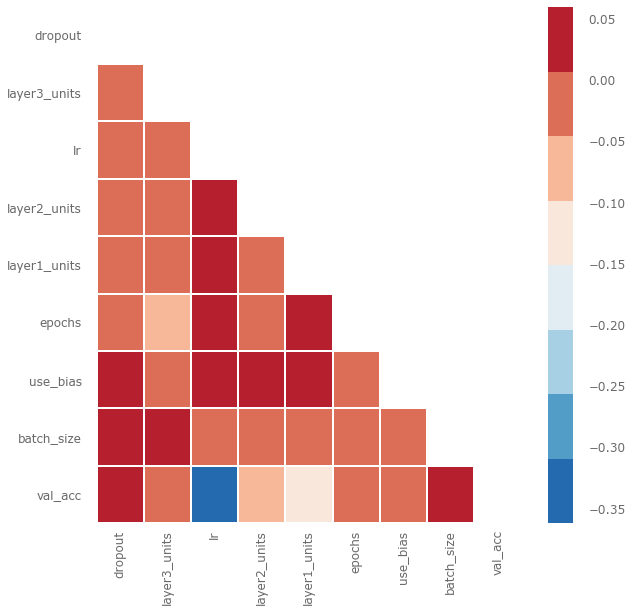

In [10]:
report.plot_corr('val_acc', ['f1score', 'val_loss', 'val_f1score', 'acc', 'loss', 'optimizer', 'None', 
                        'activation1', 'activation2', 'kernel_initializer', 'losses', 'index_num', 'round_epochs'])

KDE plots are used to visualize the Probability Density of a continuous variable. It depicts the probability density at different values of a continuous variable.

With a two dimensional KDE plot we can visualize the probability distribution of a sample against multiple continuous attributes.

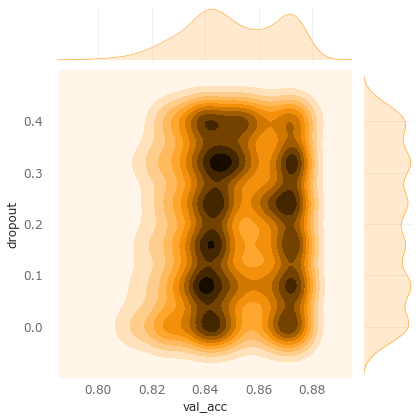

In [15]:
sns.jointplot(report.data['val_acc'], report.data['dropout'], kind='kde', color='#FFAE42')

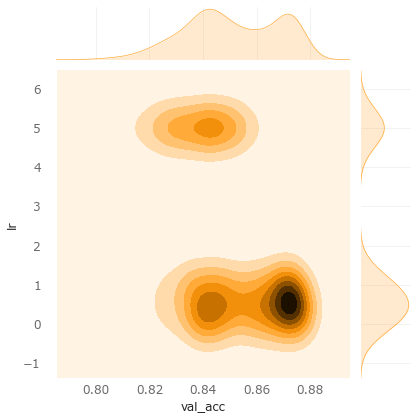

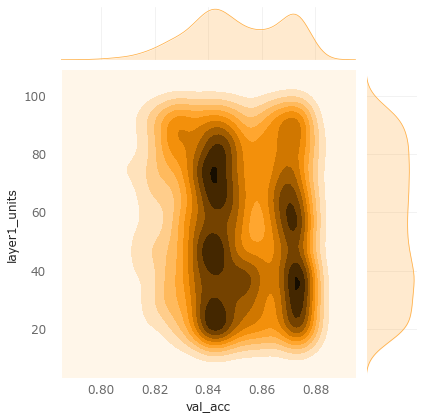

In [16]:
sns.jointplot(report.data['val_acc'], report.data['lr'], kind='kde', color='#FFAE42')
sns.jointplot(report.data['val_acc'], report.data['layer1_units'], kind='kde', color='#FFAE42'); plt.show()

In [61]:
# Experiment not successful = try adding another layer
params2 = {
    'layer1_units': list(range(40,85,4)),
    ## slightly decreased
    'layer2_units': list(range(15,30,3)),
    'layer3_units': list(range(20,35,3)),
    'layer4_units': list(range(20,35,3)),
    'optimizer': [Adam, RMSprop],
    # decreased
    'lr': [0.25, 0.5, 0.75, 0.1, 0.15, 0.175, 0.2],
    'kernel_initializer': ['normal'],
    'use_bias': [True],
    'activation1': ['relu'],
    'activation2': ['sigmoid'],
    'dropout': list(np.linspace(0, 0.35, 3)),
    'losses': ['binary_crossentropy'],
    ## decreased
    'epochs': list(range(100, 120, 5)),
    # increased
    'batch_size': list(range(35, 90, 5)),
}
params2

{'layer1_units': [40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84],
 'layer2_units': [15, 18, 21, 24, 27],
 'layer3_units': [20, 23, 26, 29, 32],
 'layer4_units': [20, 23, 26, 29, 32],
 'optimizer': [tensorflow.python.keras.optimizer_v2.adam.Adam,
  tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop],
 'lr': [0.25, 0.5, 0.75, 0.1, 0.15, 0.175, 0.2],
 'kernel_initializer': ['normal'],
 'use_bias': [True],
 'activation1': ['relu'],
 'activation2': ['sigmoid'],
 'dropout': [0.0, 0.175, 0.35],
 'losses': ['binary_crossentropy'],
 'epochs': [100, 105, 110, 115],
 'batch_size': [35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]}

In [62]:
def customer_exit_model2(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    
    model.add(Dense(params['layer1_units'], input_dim=x_train.shape[1], activation=params['activation1'],
                   kernel_initializer=params['kernel_initializer']))
    model.add(Dense(params['layer2_units'], input_dim=x_train.shape[1], activation=params['activation1'],
                   kernel_initializer=params['kernel_initializer']))
    model.add(Dense(params['layer3_units'], input_dim=x_train.shape[1], activation=params['activation1'],
                   kernel_initializer=params['kernel_initializer']))
    model.add(Dense(params['layer4_units'], input_dim=x_train.shape[1], activation=params['activation1'],
                   kernel_initializer=params['kernel_initializer']))
    model.add(Dropout(params['dropout']))
    model.add(Dense(1, activation=params['activation2'], kernel_initializer=params['kernel_initializer'], 
                                                                       use_bias=params['use_bias']))
    
    model.compile(loss=params['losses'], 
                  optimizer=params['optimizer'](lr_normalizer(params['lr'], params['optimizer'])),
                  # For this dataset, using accuracy as a metric is basically ok
                  metrics=['acc', talos.utils.metrics.f1score])

    history = model.fit(x_train, y_train, 
                   validation_data=[x_val, y_val],
                   batch_size=params['batch_size'],
                   epochs=params['epochs'],
                   verbose=0,
                   shuffle=True,)

    return history, model

In [63]:
t = talos.Scan(x=train_features,
               y=train_labels,
               val_split=0.25,
               model=customer_exit_model2,
               params=params2,
               experiment_name='Customer exit prediction',
               fraction_limit = 0.0002,
#                random_method='quantum',
#                reduction_method='corelation',
#                reduction_interval=10,
#                reduction_window=20,
#                reduction_threshold=0.6,
#                reduction_metric='fmeasure',
              )



  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 1/554 [00:34<5:14:20, 34.11s/it]

  0%|          | 2/554 [00:57<4:43:28, 30.81s/it]

  1%|          | 3/554 [01:14<4:06:51, 26.88s/it]

  1%|          | 4/554 [01:30<3:35:40, 23.53s/it]

  1%|          | 5/554 [01:48<3:19:54, 21.85s/it]

  1%|          | 6/554 [02:05<3:05:11, 20.28s/it]

  1%|▏         | 7/554 [02:19<2:48:30, 18.48s/it]

  1%|▏         | 8/554 [02:38<2:48:44, 18.54s/it]

  2%|▏         | 9/554 [02:58<2:53:35, 19.11s/it]

  2%|▏         | 10/554 [03:26<3:16:56, 21.72s/it]

  2%|▏         | 11/554 [03:42<3:00:52, 19.99s/it]

  2%|▏         | 12/554 [04:08<3:18:11, 21.94s/it]

  2%|▏         | 13/554 [04:24<3:02:02, 20.19s/it]

  3%|▎         | 14/554 [04:46<3:05:14, 20.58s/it]

  3%|▎         | 15/554 [05:02<2:53:57, 19.36s/it]

  3%|▎         | 16/554 [05:25<3:01:14, 20.21s/it]

  3%|▎         | 17/554 [05:56<3:29:39, 23.43s/it]

  3%|▎         | 18/554 [06:31<4:02:26, 27.14s/it]

  3%|▎         | 19/554 [06:52

 25%|██▌       | 140/554 [52:51<2:39:45, 23.15s/it]

 25%|██▌       | 141/554 [53:12<2:35:45, 22.63s/it]

 26%|██▌       | 142/554 [53:31<2:28:48, 21.67s/it]

 26%|██▌       | 143/554 [53:50<2:22:38, 20.82s/it]

 26%|██▌       | 144/554 [54:21<2:42:41, 23.81s/it]

 26%|██▌       | 145/554 [54:40<2:32:26, 22.36s/it]

 26%|██▋       | 146/554 [55:15<2:57:39, 26.13s/it]

 27%|██▋       | 147/554 [55:45<3:04:23, 27.18s/it]

 27%|██▋       | 148/554 [56:08<2:56:24, 26.07s/it]

 27%|██▋       | 149/554 [56:32<2:50:51, 25.31s/it]

 27%|██▋       | 150/554 [56:55<2:46:45, 24.76s/it]

 27%|██▋       | 151/554 [57:50<3:46:33, 33.73s/it]

 27%|██▋       | 152/554 [58:25<3:49:47, 34.30s/it]

 28%|██▊       | 153/554 [58:48<3:26:34, 30.91s/it]

 28%|██▊       | 154/554 [59:16<3:20:13, 30.03s/it]

 28%|██▊       | 155/554 [59:41<3:08:17, 28.31s/it]

 28%|██▊       | 156/554 [1:00:17<3:24:13, 30.79s/it]

 28%|██▊       | 157/554 [1:00:43<3:13:46, 29.29s/it]

 29%|██▊       | 158/554 [1:01:31<3:49:36,

 49%|████▉     | 274/554 [1:44:59<1:44:48, 22.46s/it]

 50%|████▉     | 275/554 [1:45:20<1:41:21, 21.80s/it]

 50%|████▉     | 276/554 [1:45:39<1:37:04, 20.95s/it]

 50%|█████     | 277/554 [1:46:10<1:51:31, 24.16s/it]

 50%|█████     | 278/554 [1:46:34<1:50:56, 24.12s/it]

 50%|█████     | 279/554 [1:46:53<1:43:16, 22.53s/it]

 51%|█████     | 280/554 [1:47:14<1:40:18, 21.97s/it]

 51%|█████     | 281/554 [1:47:30<1:31:18, 20.07s/it]

 51%|█████     | 282/554 [1:47:54<1:37:25, 21.49s/it]

 51%|█████     | 283/554 [1:48:15<1:35:41, 21.19s/it]

 51%|█████▏    | 284/554 [1:48:33<1:30:45, 20.17s/it]

 51%|█████▏    | 285/554 [1:48:50<1:26:26, 19.28s/it]

 52%|█████▏    | 286/554 [1:49:10<1:27:03, 19.49s/it]

 52%|█████▏    | 287/554 [1:49:31<1:29:29, 20.11s/it]

 52%|█████▏    | 288/554 [1:49:52<1:29:16, 20.14s/it]

 52%|█████▏    | 289/554 [1:50:18<1:37:53, 22.17s/it]

 52%|█████▏    | 290/554 [1:50:40<1:36:11, 21.86s/it]

 53%|█████▎    | 291/554 [1:50:59<1:31:59, 20.98s/it]

 53%|█████

 74%|███████▎  | 408/554 [2:58:29<1:58:14, 48.59s/it]

 74%|███████▍  | 409/554 [3:00:01<2:29:03, 61.68s/it]

 74%|███████▍  | 410/554 [3:00:34<2:07:33, 53.15s/it]

 74%|███████▍  | 411/554 [3:01:04<1:50:18, 46.28s/it]

 74%|███████▍  | 412/554 [3:01:39<1:41:39, 42.96s/it]

 75%|███████▍  | 413/554 [3:02:22<1:40:24, 42.73s/it]

 75%|███████▍  | 414/554 [3:02:46<1:26:38, 37.13s/it]

 75%|███████▍  | 415/554 [3:03:36<1:35:19, 41.14s/it]

 75%|███████▌  | 416/554 [3:04:06<1:26:35, 37.65s/it]

 75%|███████▌  | 417/554 [3:04:32<1:18:24, 34.34s/it]

 75%|███████▌  | 418/554 [3:05:01<1:13:50, 32.57s/it]

 76%|███████▌  | 419/554 [3:05:34<1:13:37, 32.72s/it]

 76%|███████▌  | 420/554 [3:06:16<1:19:16, 35.49s/it]

 76%|███████▌  | 421/554 [3:06:54<1:20:12, 36.18s/it]

 76%|███████▌  | 422/554 [3:07:30<1:19:38, 36.20s/it]

 76%|███████▋  | 423/554 [3:08:02<1:16:38, 35.10s/it]

 77%|███████▋  | 424/554 [3:08:35<1:14:43, 34.49s/it]

 77%|███████▋  | 425/554 [3:09:06<1:11:25, 33.22s/it]

 77%|█████

 98%|█████████▊| 545/554 [4:12:18<03:42, 24.75s/it]

 99%|█████████▊| 546/554 [4:12:37<03:03, 22.96s/it]

 99%|█████████▊| 547/554 [4:13:00<02:41, 23.14s/it]

 99%|█████████▉| 548/554 [4:13:21<02:13, 22.29s/it]

 99%|█████████▉| 549/554 [4:13:37<01:42, 20.54s/it]

 99%|█████████▉| 550/554 [4:13:57<01:21, 20.41s/it]

 99%|█████████▉| 551/554 [4:14:28<01:10, 23.48s/it]

100%|█████████▉| 552/554 [4:15:06<00:55, 27.92s/it]

100%|█████████▉| 553/554 [4:15:28<00:26, 26.22s/it]

100%|██████████| 554/554 [4:15:45<00:00, 27.70s/it]


In [53]:
report2 = talos.Reporting('report/report7.csv')
print('Highest validation accuracy:', round(100*report2.high('val_acc'),2))
print('Highest validation f1 score:', round(100*report2.high('val_f1score'), 2))
print('Number of rounds it took to find the best model', report2.rounds2high('val_acc'))

Highest validation accuracy: 86.4
Highest validation f1 score: 59.35
Number of rounds it took to find the best model 126


In [18]:
report2.best_params('val_acc', [], 10, True)

,layer4_units,optimizer,dropout,layer2_units,losses,round_epochs,f1score,acc,loss,kernel_initializer,...,epochs,use_bias,val_loss,val_f1score,activation1,activation2,layer3_units,layer1_units,batch_size,index_num
27,15,<class 'tensorflow.python.keras.optimizer_v2.r...,0.00,27,binary_crossentropy,100,0.459506,0.848533,0.374745,normal,...,100,True,0.429284,0.454719,relu,sigmoid,23,39,40,0
310,24,<class 'tensorflow.python.keras.optimizer_v2.a...,0.30,30,binary_crossentropy,130,0.777931,0.921600,0.224904,normal,...,130,True,0.509708,0.553553,relu,sigmoid,29,67,40,1
342,24,<class 'tensorflow.python.keras.optimizer_v2.r...,0.45,21,binary_crossentropy,124,0.492798,0.847200,0.384893,normal,...,124,True,0.426370,0.440508,relu,sigmoid,23,51,60,2
226,15,<class 'tensorflow.python.keras.optimizer_v2.a...,0.30,33,binary_crossentropy,118,0.734573,0.908267,0.249867,normal,...,118,True,0.455727,0.525108,relu,sigmoid,26,63,55,3
136,24,<class 'tensorflow.python.keras.optimizer_v2.a...,0.45,18,binary_crossentropy,100,0.484760,0.851733,0.388537,normal,...,100,True,0.426951,0.426321,relu,sigmoid,32,35,70,4
73,21,<class 'tensorflow.python.keras.optimizer_v2.r...,0.15,33,binary_crossentropy,106,0.481407,0.847733,0.377552,normal,...,106,True,0.423757,0.453664,relu,sigmoid,29,35,40,5
93,15,<class 'tensorflow.python.keras.optimizer_v2.r...,0.00,18,binary_crossentropy,112,0.488103,0.849867,0.367560,normal,...,112,True,0.415074,0.425796,relu,sigmoid,23,39,65,6
390,21,<class 'tensorflow.python.keras.optimizer_v2.r...,0.30,21,binary_crossentropy,112,0.461359,0.845333,0.391276,normal,...,112,True,0.430225,0.435175,relu,sigmoid,26,39,65,7
269,15,<class 'tensorflow.python.keras.optimizer_v2.r...,0.00,21,binary_crossentropy,136,0.493103,0.849067,0.369541,normal,...,136,True,0.432376,0.428069,relu,sigmoid,23,43,55,8
146,18,<class 'tensorflow.python.keras.optimizer_v2.r...,0.30,30,binary_crossentropy,118,0.463524,0.848533,0.382313,normal,...,118,True,0.428923,0.451562,relu,sigmoid,23,43,35,9


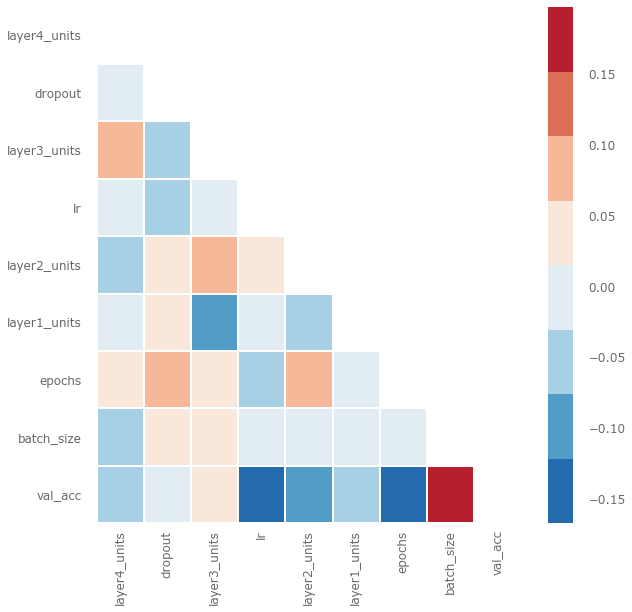

In [41]:
report2.plot_corr('val_acc', ['f1score', 'val_loss', 'val_f1score', 'acc', 'loss', 'optimizer', 'None', 
                        'activation1', 'activation2', 'kernel_initializer', 'losses', 'index_num', 'use_bias', 'round_epochs'])

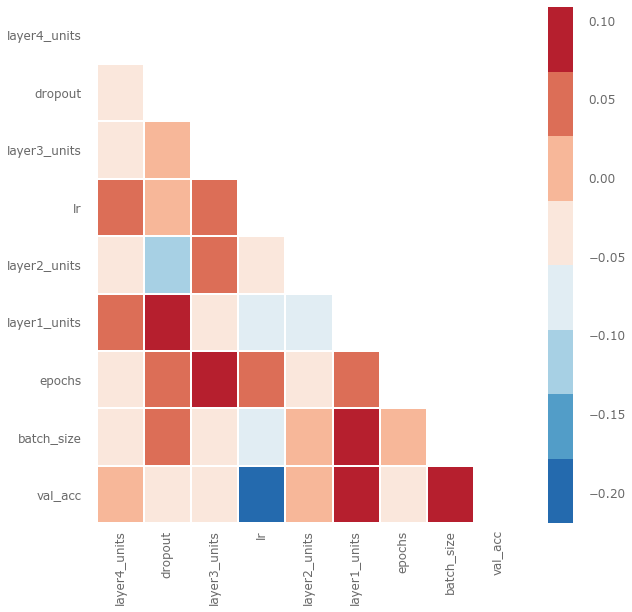

In [54]:
report2.plot_corr('val_acc', ['f1score', 'val_loss', 'val_f1score', 'acc', 'loss', 'optimizer', 'None', 
                        'activation1', 'activation2', 'kernel_initializer', 'losses', 'index_num', 'use_bias', 'round_epochs'])

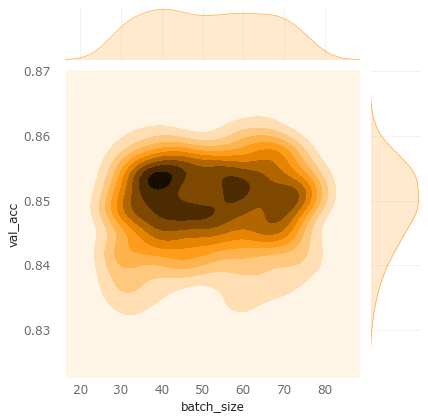

In [59]:
sns.jointplot(report2.data['batch_size'], report2.data['val_acc'], kind='kde', color='#FFAE42'); plt.show()